### Time  Series analysis

In [153]:
import site
site.addsitedir('./code')
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa
import nsfg
import thinkstats2

In [8]:
transactions = pd.read_csv('./code/mj-clean.csv', parse_dates=[5])
transactions.head(4)

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521


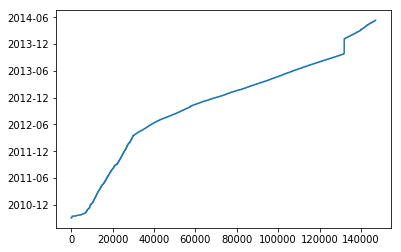

In [10]:
transactions.date.plot()

The DataFrame has a row for each reported transaction and the following
columns:
- city: string city name.
- state: two-letter state abbreviation.
- price: price paid in dollars.
- amount: quantity purchased in grams.
- quality: high, medium, or low quality, as reported by the purchaser. 
- date: date of report, presumed to be shortly after date of purchase. 
- ppg: price per gram, in dollars.
- state.name: string state name.
- lat: approximate latitude of the transaction, based on city name.
- lon: approximate longitude of the transaction.
Each transaction is an event in time, so we could treat this dataset as a time series.But the events are not equally spaced in time; the number of transactions reported each day varies from 0 to several hundred. Many methods used to analyze time series require the measurements to be equally spaced.

In [31]:
q_gr=transactions.groupby('quality')
dailies = {}
for name, gr in q_gr:
    groups = gr[['date', 'ppg']].groupby('date')
    daily = groups.aggregate(np.mean)
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    dailies[name] = daily

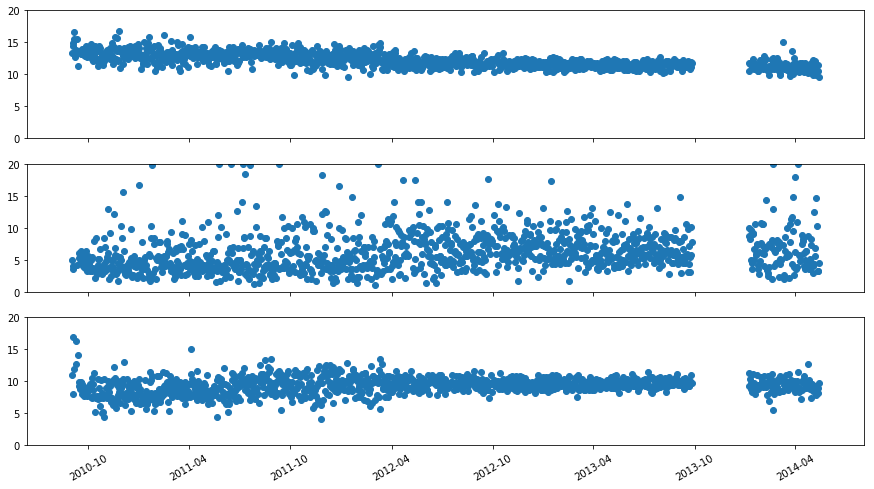

In [66]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,8))
for i, a in enumerate(ax):
    a.set_ylim([0,20])
    if i == 2:
        plt.setp(a.get_xticklabels(), rotation=30)
    else:
        plt.setp(a.set_xticklabels([]))
        
for i, (name, daily) in enumerate(dailies.items()):
    ax[i].scatter(daily.index, daily.ppg)
    
# axes = plt.gca()
# axes.set_ylim([0,20])

Although there are methods specific to time series analysis, for many prob- lems a simple way to get started is by applying general-purpose tools like linear regression.

In [97]:
for n, d in dailies.items():
    m = smf.ols('ppg ~ years', data=d)
    res = m.fit()
    print('name {} {} \n\n'.format(n, res.summary()))

name high                             OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          3.69e-160
Time:                        15:00:07   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.08

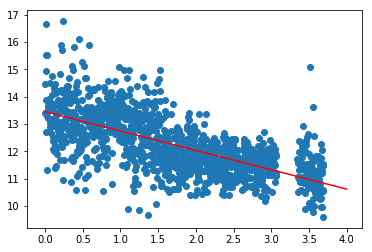

In [96]:
x1=np.linspace(0, 4)
y1 = -0.7082*x1+13.4496
plt.plot(x1, y1, color='red')
plt.scatter(dailies['high'].years,dailies['high'].ppg)

The estimated slopes indicate that the price of high quality cannabis dropped by about 71 cents per year during the observed interval; for medium quality it increased by 28 cents per year, and for low quality it increased by 57 cents per year. These estimates are all statistically significant with very small p-values.

- First, there is no reason to expect the long-term trend to be a line or any other simple function. In general, prices are determined by supply and demand, both of which vary over time in unpredictable ways.
- Second, the linear regression model gives equal weight to all data, recent and past. For purposes of prediction, we should probably give more weight to recent data.
- Finally, one of the assumptions of linear regression is that the residuals are uncorrelated noise. With time series data, this assumption is often false because successive values are correlated.

### Moving averages
Most time series analysis is based on the modeling assumption that the ob- served series is the sum of three components:
- Trend: A smooth function that captures persistent changes.
- Seasonality: Periodic variation, possibly including daily, weekly,
monthly, or yearly cycles.
- Noise: Random variation around the long-term trend.
Regression is one way to extract the trend from a series, as we saw in the previous section. But if the trend is not a simple function, a good alternative is a moving average. A moving average divides the series into overlapping regions, called windows, and computes the average of the values in each window.
Before we can apply rolling_mean to the cannabis data, we have to deal with missing values. There are a few days in the observed interval with no reported transactions for one or more quality categories, and a period in 2013 when data collection was not active.

In the DataFrames we have used so far, these dates are absent; the index skips days with no data. For the analysis that follows, we need to represent this missing data explicitly. 

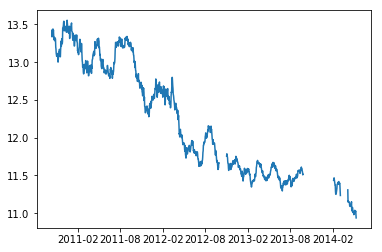

In [104]:
dates = pd.date_range(dailies['high'].index.min(), dailies['high'].index.max())
reind = dailies['high'].reindex(dates)
roll_mean = reind.ppg.rolling(30).mean()
plt.plot(roll_mean.index, roll_mean)

The rolling mean seems to do a good job of smoothing out the noise and extracting the trend. The first 29 values are nan, and wherever there’s a missing value, it’s followed by another 29 nans.

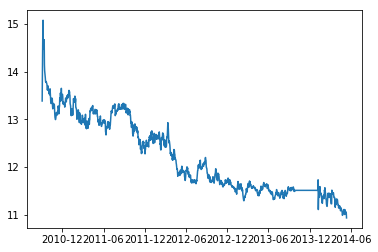

In [116]:
ewma = reind.ppg.ewm(span=30).mean()
plt.plot(ewma.index, ewma)

### Missing values


In [120]:
resid = (reind.ppg - ewma).dropna()
fake_data = ewma + np.random.choice(resid, size=len(reind))
reind.ppg.fillna(fake_data, inplace=True)

As prices vary from day to day, you might expect to see patterns. If the price is high on Monday, you might expect it to be high for a few more days; and if it’s low, you might expect it to stay low. A pattern like this is called serial
correlation, because each value is correlated with the next one in the series.
To compute serial correlation, we can shift the time series by an interval called a lag, and then compute the correlation of the shifted series with the original.

If we apply SerialCorr to the raw price data with lag 1, we find serial correlation 0.48 for the high quality category, 0.16 for medium and 0.10 for low. In any time series with a long-term trend, we expect to see strong serial correlations; for example, if prices are falling, we expect to see values above the mean in the first half of the series and values below the mean in the second half.

In [123]:
lag=1
xs = reind[lag:].ppg
ys = reind.shift(lag)[lag:].ppg
corr = np.corrcoef(xs,ys)

In [136]:
corr

array([[1.        , 0.07350282],
       [0.07350282, 1.        ]])

If we apply SerialCorr to the raw price data with lag 1, we find serial correlation 0.48 for the high quality category, 0.16 for medium and 0.10 for low. In any time series with a long-term trend, we expect to see strong serial correlations; for example, if prices are falling, we expect to see values above the mean in the first half of the series and values below the mean in the second half.
It is more interesting to see if the correlation persists if you subtract away the trend. For example, we can compute the residual of the EWMA and then compute its serial correlation:
    ewma = pandas.ewma(reindexed.ppg, span=30)
    resid = reindexed.ppg - ewma
    corr = SerialCorr(resid, 1)
With lag=1, the serial correlations for the de-trended data are -0.022 for high quality, -0.015 for medium, and 0.036 for low. These values are small, indicating that there is little or no one-day serial correlation in this series.
To check for weekly, monthly, and yearly seasonality, I ran the analysis again with different lags. Here are the results:
 
lag
high
medium
low
1
7 30 365
-0.029 0.02 0.014 0.045
-0.014
-0.042 -0.0064 0.015
0.034 -0.0097 -0.013 0.033

In [145]:
acf = smtsa.acf(reind.ppg, nlags=365, unbiased=True)
acf[0], acf[1], acf[7], acf[30], acf[365]

(1.0,
 0.476658275918951,
 0.4738125353081164,
 0.44062597765276695,
 0.16968799268466914)

Modeling errors and unexpected future events are hard to quantify. Sampling error and random variation are easier to deal with, so we’ll do that first.

### Survival analysis
Survival analysis is a way to describe how long things last.
It is often used to study human lifetimes, but it also applies to “survival” of mechanical and electronic components, or more generally to intervals in time before an event.
The fundamental concept in survival analysis is the survival curve, S(t), which is a function that maps from a duration, t, to the probability of surviv- ing longer than t.

Finding the survival curve is easy; it’s just the complement of the CDF:
$S(t) = 1 − CDF(t)$
where CDF(t) is the probability of a lifetime less than or equal to t.

In [154]:
preg = nsfg.ReadFemPreg(dct_file='./code/2002FemPreg.dct', dat_file='./code/2002FemPreg.dat.gz')
complete = preg.query('outcome in [1, 3, 4]').prglngth
cdf = thinkstats2.Cdf(complete, label='cdf')

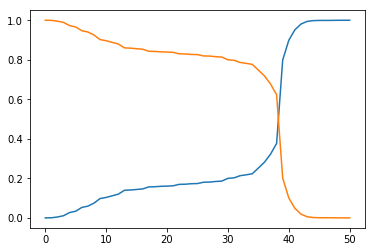

In [169]:
plt.plot(cdf.xs, cdf.ps)
plt.plot(cdf.xs, 1- cdf.ps)

About 86% of pregnancies proceed past the first trimester; about 14% do not. The curve is nearly flat between 13 and 26 weeks, which shows that few pregnancies end in the second trimester. And the curve is steepest around 39 weeks, which is the most common pregnancy length.

### Hazard function


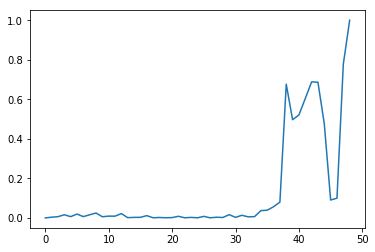

In [171]:
ts = cdf.ps
ss  = 1 - cdf.ps
hzrd = []
for i, t in enumerate(ts[:-1]):
    hzrd.append((ss[i] - ss[i+1])/ss[i])
    
plt.plot(hzrd)

So of all pregnancies that proceed until week 39, about 50% end in week 39.
For times after week 42, the hazard function is erratic because it is based on a small number of cases. Other than that the shape of the curve is as expected: it is highest around 39 weeks, and a little higher in the first trimester than in the second.
If someone gives you the CDF of lifetimes, it is easy to compute the survival and hazard functions. But in many real-world scenarios, we can’t measure the distribution of lifetimes directly. We have to infer it.
For example, suppose you are following a group of patients to see how long they survive after diagnosis. Not all patients are diagnosed on the same day, so at any point in time, some patients have survived longer than others. If some patients have died, we know their survival times. For patients who are still alive, we don’t know survival times, but we have a lower bound.
If we wait until all patients are dead, we can compute the survival curve, but if we are evaluating the effectiveness of a new treatment, we can’t wait that long! We need a way to estimate survival curves using incomplete informa- tion.

### Kaplan-Meier estimation